<a href="https://colab.research.google.com/github/IvanIsCoding/GNN-for-Combinatorial-Optimization/blob/main/01_GNN_vs_SA_for_Max_Cut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is where we compare Graph Neural Networks vs Simulated Annealing

https://arxiv.org/abs/2206.13211

In [1]:
!pip install -q git+https://github.com/IvanIsCoding/GNN-for-Combinatorial-Optimization.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 KB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.1/238.1 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 10.6 MB/s eta

We saw the definition of GNNs on the previous one, time to see what simulated annealing is about

In [2]:
from gnn_for_co.core import create_train_state, train_step, get_classification, create_Q_matrix, create_max_cut_model

import jax
import jax.numpy as jnp
import numpy as np
import networkx as nx
import openjij as oj
from tqdm.notebook import trange, tqdm

In [3]:
G = nx.convert_node_labels_to_integers(nx.fast_gnp_random_graph(n = 100, p=0.05, seed=2023))

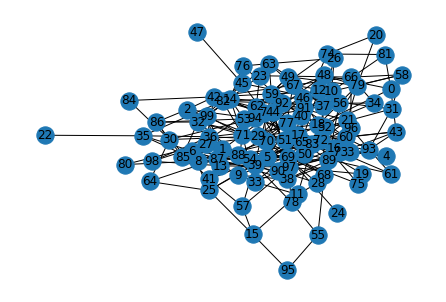

In [4]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), with_labels=True)

In [5]:
sampler = oj.SASampler()

In [6]:
model = create_max_cut_model(G)
qubo_dict, offset = model.to_qubo()

In [7]:
response = sampler.sample_qubo(qubo_dict, num_reads=1000)

In [8]:
response.first.energy

-213.0

In [14]:
node_color = ["lightblue" for i in range(G.number_of_nodes())]
for x, val in response.first.sample.items():
  if val == 1:
    node_color[int(x[2:-1])] = "yellow"

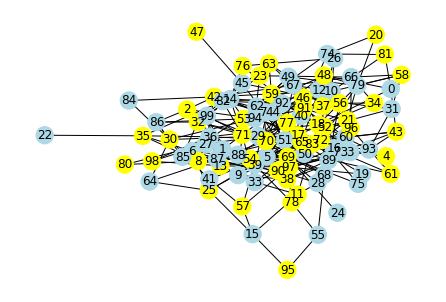

In [15]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), node_color=node_color, with_labels=True)

Notice that simulated annealing found a better solution. Time to 

In [17]:
def solve_with_gnn(G, embedding_size, hidden_size, learning_rate, epochs, dropout_rate, seed=2023, verbose=False):
  A = jnp.array(nx.to_numpy_array(G))
  Q = create_Q_matrix(G)

  rng = jax.random.PRNGKey(2023)
  rng, init_rng = jax.random.split(rng)
  rng, embed_rng = jax.random.split(rng)
  state = create_train_state(G.number_of_nodes(), embedding_size, hidden_size, init_rng, learning_rate, dropout_frac=0.01)
  node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

  for epoch in trange(1, num_epochs + 1, disable=not verbose):
    rng, dropout_rng = jax.random.split(rng)
    state, metrics = train_step(state=state, node_embeddings=node_embeddings, adj_matrix=A, q_matrix=Q, dropout_rng=dropout_rng)

    if epoch % 25 == 0 and verbose:
      print('train epoch: %d, cost: %.2f' % (epoch, metrics["energy"]))
    
  classification = np.array(get_classification(state.apply_fn, node_embeddings, A))
  probs = state.apply_fn({"params": state.params}, node_embeddings, A)
  solution = {f"X[{i}]": classification[i] for i in range(G.number_of_nodes())}
  last_energy = metrics["energy"]

  return {
      "classification": classification,
      "probs": probs,
      "energy": last_energy,
      "solution": solution
  }

In [2]:
def solve_with_annealing(G, num_reads):
  sampler = oj.SASampler()

  model = create_max_cut_model(G)
  qubo_dict, offset = model.to_qubo()

  response = sampler.sample_qubo(qubo_dict, num_reads=num_reads)

  return {
      "sample": response.first.sample,
      "energy": response.first.energy,
      "model": model
  }